# Model creation

## feature selection, imputing, scaling and train test split

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd

df = pd.read_csv('churn_model_features.csv')

churn_features = df[['order_count_3m', 'unique_vendors_last_3m',
       'antiquity_days', 'visits_count_3m', 'tickets_finales', 'mean_order_lapse', 
       'gmv_delta_3m', 'total_discount_delta_3m', 'is_churned']].copy()

X = churn_features.drop(columns=["is_churned"], axis = 1).copy()

y = churn_features['is_churned'].copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Models testing

### Testing all the models without hyperparameter tuning

#### without smote

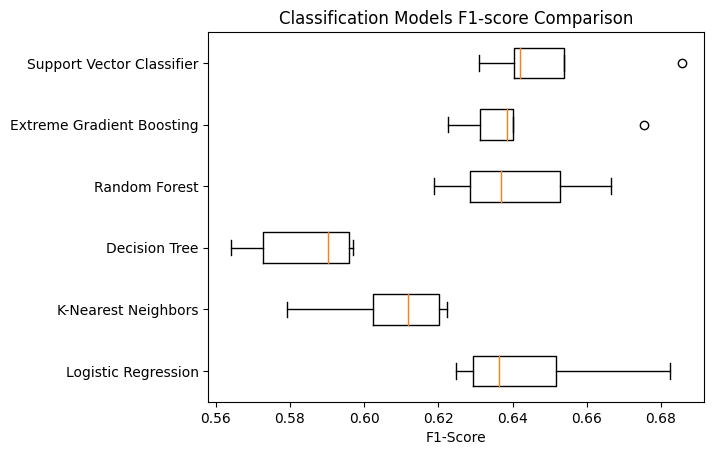

In [44]:
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Extreme Gradient Boosting": xgb.XGBClassifier(),
    "Support Vector Classifier": SVC(random_state=42, probability=True)  # 'probability=True' needed for scoring recall in SVC,
}

results = []

# Loop through the models' values
for name, model in models.items():
    # Construct the pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    # Perform cross-validation with recall as the scoring metric
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring="f1")
    
    # Append the results
    results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys(), vert=False)  # 'vert=False' for horizontal box plots
plt.xlabel('F1-Score')
plt.title('Classification Models F1-score Comparison')
plt.show()

#### with smote

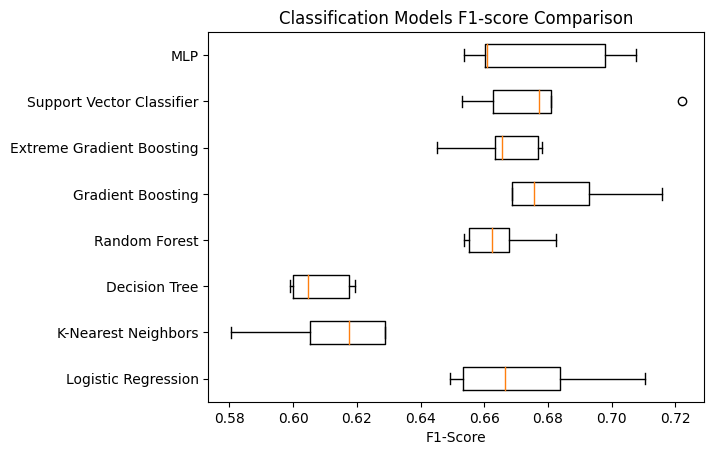

In [4]:
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=42),
    "Support Vector Classifier": SVC(random_state=42, probability=True),  # 'probability=True' needed for scoring recall in SVC
    "MLP": MLPClassifier(hidden_layer_sizes=(18, 8, 4), max_iter=1000, random_state=42, verbose= False)
}

results = []

# Loop through the models' values
for name, model in models.items():
    # Construct the pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer()),
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    # Perform cross-validation with recall as the scoring metric
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring="f1")
    
    # Append the results
    results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys(), vert=False)  # 'vert=False' for horizontal box plots
plt.xlabel('F1-Score')
plt.title('Classification Models F1-score Comparison')
plt.show()

### KNN

#### with smote

In [40]:
from sklearn.model_selection import KFold, RandomizedSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import mlflow
from mlflow import sklearn
import datetime

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"KNN_with_SMOTE_{current_time}"):
    steps = [("imputation", SimpleImputer()),
            ("SMOTE", SMOTE(random_state=42)),
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier())]

    pipeline = Pipeline(steps)

    parameters = {
        'knn__n_neighbors': np.arange(1, 31, 3),
        'knn__weights' : ['uniform', 'distance'],
        'knn__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
        }

    kf = KFold(n_splits=5, random_state=42, shuffle=True)

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=30, cv=kf, scoring = 'recall')

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "KNN_with_SMOTE")

2023/10/30 15:42:57 INFO mlflow.tracking.fluent: Experiment with name 'Churn_Prediction' does not exist. Creating a new experiment.


#### without smote

In [41]:
from sklearn.model_selection import KFold, RandomizedSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import mlflow
from mlflow import sklearn

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"KNN_{current_time}"):

    steps = [("imputation", SimpleImputer()),
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier())]

    pipeline = Pipeline(steps)

    parameters = {
        'knn__n_neighbors': np.arange(1, 31, 3),
        'knn__weights' : ['uniform', 'distance'],
        'knn__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
        }

    kf = KFold(n_splits=5, random_state=42, shuffle=True)

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=30, cv=kf, scoring = 'recall')

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "KNN")

### Logistic Regression

#### with smote

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import mlflow
from mlflow import sklearn

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"LogisticRegression_with_SMOTE_{current_time}"):
    
    steps = [("imputation", SimpleImputer()),
            ("SMOTE", SMOTE(random_state=42)),
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression())]

    pipeline = Pipeline(steps)

    parameters = {
        'logreg__C': [0.01, 0.1, 1, 10],
        'logreg__penalty': ['l1', 'l2'],
        'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'logreg__max_iter': [100, 500, 1000],
        'logreg__class_weight': [None, 'balanced'],
        'logreg__fit_intercept': [True, False]
    }

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter= 30, scoring = 'recall')

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "LogisticRegression_with_SMOTE")

#### without smote

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import mlflow
from mlflow import sklearn

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"LogisticRegression_{current_time}"):
    
    steps = [("imputation", SimpleImputer()),
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression())]

    pipeline = Pipeline(steps)

    parameters = {
        'logreg__C': [0.01, 0.1, 1, 10],
        'logreg__penalty': ['l1', 'l2'],
        'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'logreg__max_iter': [100, 500, 1000],
        'logreg__class_weight': [None, 'balanced'],
        'logreg__fit_intercept': [True, False]
    }

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter= 30, scoring = 'f1')

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "LogisticRegression")

### Support Vector Classifier

#### with smote

In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import mlflow
from mlflow import sklearn

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"Support_Vector_Classifier_with_SMOTE_{current_time}"):
    
    steps = [("imputation", SimpleImputer()),
            ("SMOTE", SMOTE(random_state=42)),
            ("scaler", StandardScaler()),
            ("SVC", SVC(probability=True))]

    pipeline = Pipeline(steps)

    parameters = {
        'SVC__C': [0.1, 1, 10, 100],  # Regularization parameter
        'SVC__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'SVC__gamma': [0.1, 1, 'auto', 'scale'],  # Kernel coefficient
        'SVC__class_weight' : [None, 'balanced'],
        'SVC__probability' : [True]
    }

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=10, scoring = 'recall', random_state=42)

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "Support_Vector_Classifier_with_SMOTE")

#### without smote

In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import mlflow
from mlflow import sklearn

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"Support_Vector_Classifier_{current_time}"):
    
    steps = [("imputation", SimpleImputer()),
            ("scaler", StandardScaler()),
            ("SVC", SVC(probability=True))]

    pipeline = Pipeline(steps)

    parameters = {
        'SVC__C': [0.1, 1, 10, 100],  # Regularization parameter
        'SVC__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'SVC__gamma': [0.1, 1, 'auto', 'scale'],  # Kernel coefficient
        'SVC__class_weight' : [None, 'balanced'],
        'SVC__probability' : [True]
    }

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=10, scoring = 'recall', random_state=42)

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "Support_Vector_Classifier")

### Random Forest

#### with smote

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import mlflow
from mlflow import sklearn

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"Random_Forest_with_SMOTE_{current_time}"):
    
    steps = [("imputation", SimpleImputer()),
            ("SMOTE", SMOTE(random_state=42)),
            ("scaler", StandardScaler()),
            ("RandomForest", RandomForestClassifier())]

    pipeline = Pipeline(steps)

    parameters = {
        'RandomForest__n_estimators': [10, 50, 100, 200, 300, 500],
        'RandomForest__criterion': ['gini', 'entropy'],
        'RandomForest__max_depth': [None, 3, 5, 7, 10, 20, 30],
        'RandomForest__min_samples_split': [2, 5, 10],
        'RandomForest__min_samples_leaf': [1, 2, 4],
        'RandomForest__bootstrap': [True, False],
        'RandomForest__class_weight': [None, 'balanced']
    }

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=50, scoring = 'recall', random_state=42)

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "Random_Forest_with_SMOTE")

#### without smote

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import mlflow
from mlflow import sklearn

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"Random_Forest_{current_time}"):
    
    steps = [("imputation", SimpleImputer()),
            ("scaler", StandardScaler()),
            ("RandomForest", RandomForestClassifier())]

    pipeline = Pipeline(steps)

    parameters = {
        'RandomForest__n_estimators': [10, 50, 100, 200, 300, 500],  
        'RandomForest__criterion': ['gini', 'entropy'],
        'RandomForest__max_depth': [None, 3, 5, 7, 10, 20, 30],
        'RandomForest__min_samples_split': [2, 5, 10], 
        'RandomForest__min_samples_leaf': [1, 2, 4], 
        'RandomForest__bootstrap': [True, False],
        'RandomForest__class_weight': [None, 'balanced']
    }

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=50, scoring = 'recall', random_state=42)

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "Random_Forest")

### Extreme Gradient Boosting (XGBoost)

#### with smote

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import xgboost as xgb
import mlflow
from mlflow import sklearn
import datetime

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"XGBoost_with_SMOTE_{current_time}"):
    
    steps = [("imputation", SimpleImputer()),
            ("SMOTE", SMOTE(random_state=42)),
            ("scaler", StandardScaler()),
            ("XGB", xgb.XGBClassifier())]

    pipeline = Pipeline(steps)

    parameters = {
        'XGB__learning_rate': [None, 0.001, 0.01, 0.1],
        'XGB__n_estimators': [50, 100, 200],
        'XGB__max_depth': [None, 3, 5, 7],
        'XGB__subsample': [0.8, 0.9, 1.0],
        'XGB__colsample_bytree': [0.7, 0.8, 0.9],
        'XGB__gamma': [0.1, 0.2],
        'XGB__lambda': [0.1, 1.0],
        'XGB__alpha': [0.1, 1.0],
        'XGB__scale_pos_weight': [3, 4, 5],
        'XGB__max_delta_step': [1, 2, 5, 10]
    }

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=50, scoring = 'f1', random_state=42)

    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "XGBoost_with_SMOTE")

#### without smote

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import xgboost as xgb
import mlflow
from mlflow import sklearn
import datetime

# Setup the experiment
mlflow.set_experiment("Churn_Prediction")

# Start a new run
current_time = datetime.datetime.now().strftime("%m/%d/%Y_%H:%M:%S")
with mlflow.start_run(run_name=f"XGBoost_{current_time}"):
    
    steps = [("imputation", SimpleImputer()),
            ("scaler", StandardScaler()),
            ("XGB", xgb.XGBClassifier())]

    pipeline = Pipeline(steps)

    parameters = {
        'XGB__learning_rate': [None, 0.001, 0.01, 0.1],
        'XGB__n_estimators': [50, 100, 200],
        'XGB__max_depth': [None, 3, 5, 7],
        'XGB__subsample': [0.8, 0.9, 1.0],
        'XGB__colsample_bytree': [0.7, 0.8, 0.9],
        'XGB__gamma': [0.1, 0.2],
        'XGB__lambda': [0.1, 1.0],
        'XGB__alpha': [0.1, 1.0],
        'XGB__scale_pos_weight': [3, 4, 5],
        'XGB__max_delta_step': [1, 2, 5, 10]
    }

    model = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=50, scoring = 'f1', random_state=42)

    model.fit(X_train, y_train)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1Score = f1_score(y_test, y_pred)
    AreaUnderCurve = roc_auc_score(y_test, y_pred_probs)

    # log parameters and metrics
    mlflow.log_params(model.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": F1Score,
        "AUC": AreaUnderCurve,
        "best_cross_val_recall": model.best_score_
    })
    
    # Log the trained model
    mlflow.sklearn.log_model(model, "XGBoost")

### MLPC (Multi-Layer Perceptron Classifier)

confusion_matrix:
[[441 199]
 [115 265]]

classification_report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       640
           1       0.57      0.70      0.63       380

    accuracy                           0.69      1020
   macro avg       0.68      0.69      0.68      1020
weighted avg       0.71      0.69      0.70      1020



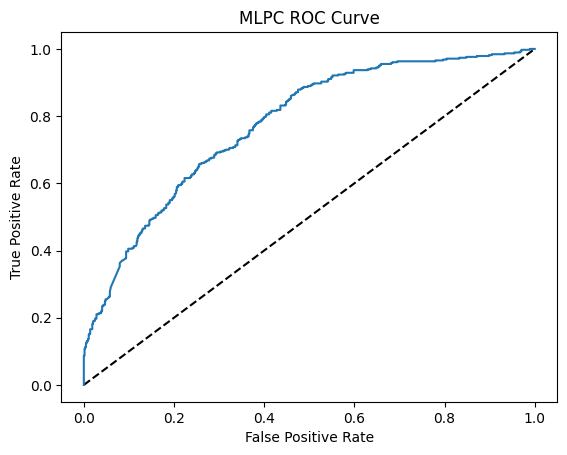

AUC
0.7749547697368421


In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.neural_network import MLPClassifier

steps = [("imputation", SimpleImputer()),
         ("SMOTE", SMOTE(random_state=42)),
         ("scaler", StandardScaler()),
         ("MLP", MLPClassifier(hidden_layer_sizes=(18, 8, 4), max_iter=1000, random_state=42, verbose= False))]
pipeline = Pipeline(steps)

# parameters = {
#     'XGB__learning_rate': [None, 0.001, 0.01, 0.1],
#     'XGB__n_estimators': [50, 100, 200],
#     'XGB__max_depth': [None, 3, 5, 7],
#     'XGB__subsample': [0.8, 0.9, 1.0],
#     'XGB__colsample_bytree': [0.7, 0.8, 0.9],
#     'XGB__gamma': [0.1, 0.2],
#     'XGB__lambda': [0.1, 1.0],
#     'XGB__alpha': [0.1, 1.0],
#     'XGB__scale_pos_weight': [3, 4, 5],
#     'XGB__max_delta_step': [1, 2, 5, 10]
# }

# tuned_XGBoost = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=50, scoring = 'f1', random_state=42)

pipeline.fit(X_train, y_train)

# print("Tuned XGBoost Parameters: {}, Best CrossValidation scoring: {}".format(tuned_XGBoost.best_params_, tuned_XGBoost.best_score_))

# Make predictions on the testing data
y_pred = pipeline.predict(X_test)

# Generate the confusion matrix and classification report
print('confusion_matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print('classification_report:')
print(classification_report(y_test, y_pred))

# Calculate ROC curve and AUC
y_pred_probs = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLPC ROC Curve')
plt.show()

print('AUC')
print(roc_auc_score(y_test, y_pred_probs))

### guardando el diccionario de los mejores hiperparametros

In [16]:
knn_best_params = {param.split('__')[1]: value for param, value in tuned_knn.best_params_.items() if param.startswith('knn__')}
logreg_best_params = {param.split('__')[1]: value for param, value in tuned_logreg.best_params_.items() if param.startswith('logreg__')}
svc_best_params = {param.split('__')[1]: value for param, value in tuned_svc.best_params_.items() if param.startswith('SVC__')}
randomforest_best_params = {param.split('__')[1]: value for param, value in tuned_rf.best_params_.items() if param.startswith('RandomForest__')}
gradientboosting_best_params = {param.split('__')[1]: value for param, value in tuned_gradientboosting.best_params_.items() if param.startswith('GradientBoosting__')}
XGBoost_best_params = {param.split('__')[1]: value for param, value in tuned_XGBoost.best_params_.items() if param.startswith('XGB__')}

In [17]:
from joblib import dump

# Create a dictionary containing all your dictionaries
dicts_to_save = {
    'knn_best_params': knn_best_params,
    'logreg_best_params': logreg_best_params,
    'svc_best_params': svc_best_params,
    'randomforest_best_params': randomforest_best_params,
    'gradientboosting_best_params': gradientboosting_best_params,
    'XGBoost_best_params': XGBoost_best_params
}

# Save all dictionaries to a file
dump(dicts_to_save, 'model_params.pkl')

['model_params.pkl']

### importando el diccionario de los mejores hiperparametros prev guardado

In [1]:
from joblib import load

loaded_dicts = load('model_params.pkl')

# Assign each dictionary to its respective variable name
knn_best_params = loaded_dicts['knn_best_params']
logreg_best_params = loaded_dicts['logreg_best_params']
svc_best_params = loaded_dicts['svc_best_params']
randomforest_best_params = loaded_dicts['randomforest_best_params']
gradientboosting_best_params = loaded_dicts['gradientboosting_best_params']
XGBoost_best_params = loaded_dicts['XGBoost_best_params']

### Analizando model output

##### plot for gmv vs churn rate

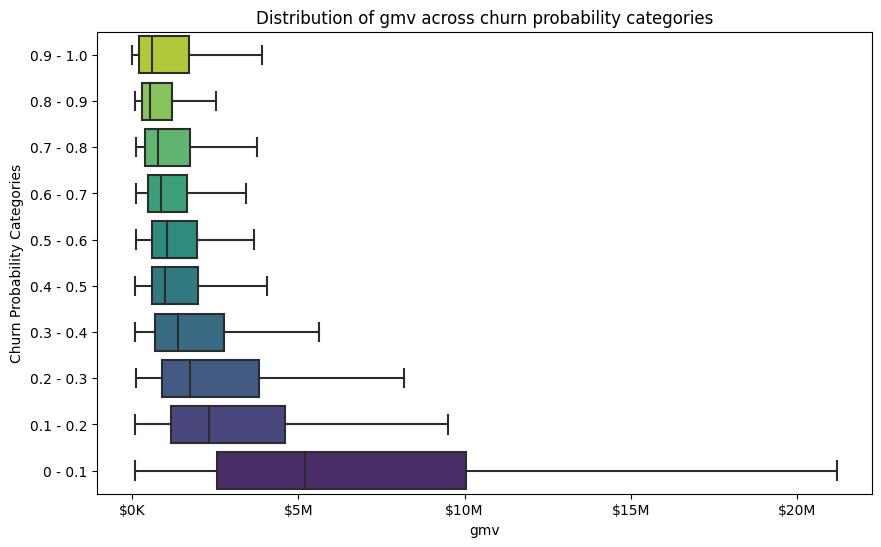

In [33]:
import mlflow
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

XGBoost_w_gmv = mlflow.sklearn.load_model("C:/Users/admin/OneDrive - Universidad del Norte/Escritorio/Churn model microservicios/mlruns/225284128156129602/a8c8894a9ac34cfd8f98f68dc9cc74a8/artifacts/XGBoost")

X['churn_prob'] = XGBoost_w_gmv.predict_proba(X)[:, 1]

# Categorizing 'churn_prob' into intervals
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = ['0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4', '0.4 - 0.5',
          '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1.0']

X['churn_category'] = pd.cut(X['churn_prob'], bins=bins, labels=labels, right=False)

# Define a function to format the x-axis numbers
def currency_formatter(x, pos):
    if x >= 1e6:
        return '${:1.0f}M'.format(x*1e-6)
    else:
        return '${:1.0f}K'.format(x*1e-3)

# Generating a horizontal boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='gmv_3m', y='churn_category', data=X, orient='h', palette='viridis', showfliers = False)
plt.title('Distribution of gmv across churn probability categories')
plt.xlabel('gmv')
plt.ylabel('Churn Probability Categories')

# Apply the format to the x-axis
formatter = FuncFormatter(currency_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()

##### plot for aov vs churn rate

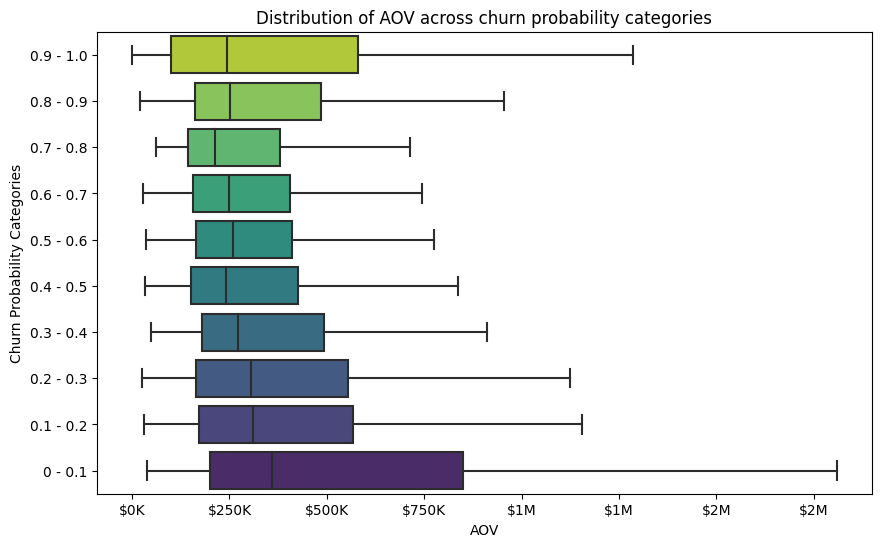

In [31]:
# import mlflow
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FuncFormatter

# XGBoost_w_AOV = mlflow.sklearn.load_model("C:/Users/admin/OneDrive - Universidad del Norte/Escritorio/Churn model microservicios/mlruns/225284128156129602/adb736bd1cd647bcb5b93c69efc70a70/artifacts/XGBoost")

# X['churn_prob'] = XGBoost_w_AOV.predict_proba(X)[:, 1]

# # Categorizing 'churn_prob' into intervals
# bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# labels = ['0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4', '0.4 - 0.5',
#           '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1.0']

# X['churn_category'] = pd.cut(X['churn_prob'], bins=bins, labels=labels, right=False)

# # Define a function to format the x-axis numbers
# def currency_formatter(x, pos):
#     if x >= 1e6:
#         return '${:1.0f}M'.format(x*1e-6)
#     else:
#         return '${:1.0f}K'.format(x*1e-3)

# # Generating a horizontal boxplot
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='AOV_3m', y='churn_category', data=X, orient='h', palette='viridis', showfliers = False)
# plt.title('Distribution of AOV across churn probability categories')
# plt.xlabel('AOV')
# plt.ylabel('Churn Probability Categories')

# # Apply the format to the x-axis
# formatter = FuncFormatter(currency_formatter)
# plt.gca().xaxis.set_major_formatter(formatter)

# # Invert the y-axis
# plt.gca().invert_yaxis()

# plt.show()

##### plot order_count vs churn rate

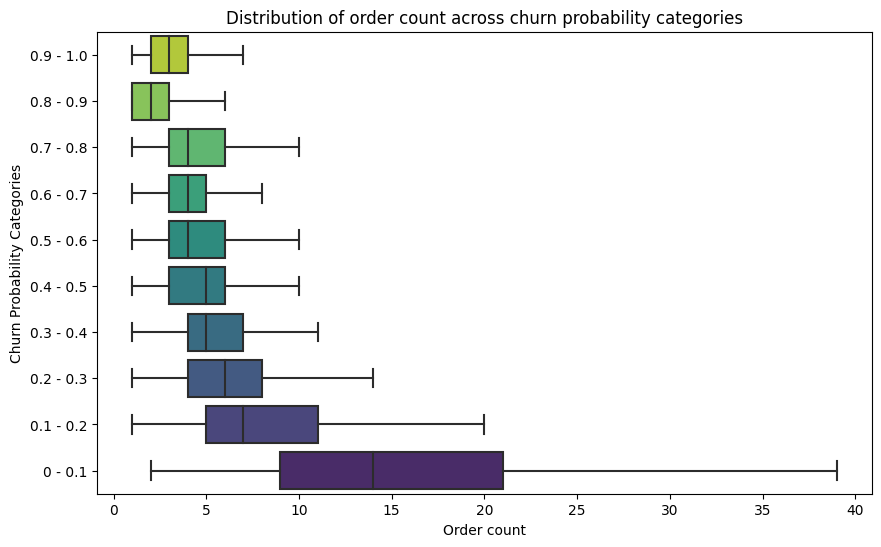

In [10]:
import mlflow
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

XGBoost_w_AOV = mlflow.sklearn.load_model("C:/Users/admin/OneDrive - Universidad del Norte/Escritorio/Churn model microservicios/mlruns/225284128156129602/f62f7c302a1f497fa182608d76bf3f1b/artifacts/XGBoost")

X['churn_prob'] = XGBoost_w_AOV.predict_proba(X)[:, 1]

# Categorizing 'churn_prob' into intervals
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = ['0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4', '0.4 - 0.5',
          '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1.0']

X['churn_category'] = pd.cut(X['churn_prob'], bins=bins, labels=labels, right=False)

# Generating a horizontal boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_count_3m', y='churn_category', data=X, orient='h', palette='viridis', showfliers = False)
plt.title('Distribution of order count across churn probability categories')
plt.xlabel('Order count')
plt.ylabel('Churn Probability Categories')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()

## Voting Classifier

In [19]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# models are created unpacking parameters
KNN_clasif = KNeighborsClassifier(**knn_best_params)
logreg_clasif = LogisticRegression(**logreg_best_params)
SVC_clasif = SVC(**svc_best_params)
RF_clasif = RandomForestClassifier(**randomforest_best_params)
GradientBoosting_clasif = GradientBoostingClassifier(**gradientboosting_best_params)
XGBoost = xgb.XGBClassifier(**XGBoost_best_params)

steps = [
    ("imputation", SimpleImputer()),
    ("SMOTE", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("clf_voting", VotingClassifier(
        estimators=[
            # ('knn', KNN_clasif),
            ('logreg', logreg_clasif),
            ('svc', SVC_clasif),
            ('randomforest', RF_clasif),
            ('XGBoost', XGBoost)
            ]
        )
    )
]

clf_voting_pipeline = Pipeline(steps)

clf_voting_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputation', SimpleImputer()),
                ('SMOTE', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('clf_voting',
                 VotingClassifier(estimators=[('logreg',
                                               LogisticRegression(C=0.01,
                                                                  penalty='l1',
                                                                  solver='liblinear')),
                                              ('svc',
                                               SVC(C=0.1,
                                                   class_weight='balanced',
                                                   gamma='auto', kernel='poly',
                                                   probability=True)),
                                              ('randomforest',
                                               RandomForestClassifier(boo...
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=0.1,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             lambda=0.1,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=1,
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None, ...))]))])

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the testing data
y_pred = clf_voting_pipeline.predict(X_test)

# Generate the confusion matrix and classification report
print('confusion_matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print('classification_report:')
print(classification_report(y_test, y_pred))

confusion_matrix:
[[431 209]
 [ 94 286]]

classification_report:
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       640
           1       0.58      0.75      0.65       380

    accuracy                           0.70      1020
   macro avg       0.70      0.71      0.70      1020
weighted avg       0.73      0.70      0.71      1020



haciendo el preprocesamiento sin pipeline

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# models are created unpacking parameters
KNN_clasif = KNeighborsClassifier(**knn_best_params)
logreg_clasif = LogisticRegression(**logreg_best_params)
SVC_clasif = SVC(**svc_best_params)
RF_clasif = RandomForestClassifier(**randomforest_best_params)
GradientBoosting_clasif = GradientBoostingClassifier(**gradientboosting_best_params)

X_train_imputed = SimpleImputer(strategy='mean').fit_transform(X_train)
X_train_scaled = StandardScaler().fit_transform(X_train_imputed)
X_test_imputed = SimpleImputer(strategy='mean').fit_transform(X_test)
X_test_scaled = StandardScaler().fit_transform(X_test_imputed)

clf_voting = VotingClassifier(
    estimators=[
        ('knn', KNN_clasif),
        ('logreg', logreg_clasif),
        ('svc', SVC_clasif),
        ('randomforest', RF_clasif),
        ('gradientboosting', GradientBoosting_clasif)
    ]
)

clf_voting.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = clf_voting.predict(X_test_scaled)

# Generate the confusion matrix and classification report
print('confusion_matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print('classification_report:')
print(classification_report(y_test, y_pred))

confusion_matrix:
[[495 145]
 [135 245]]

classification_report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       640
           1       0.63      0.64      0.64       380

    accuracy                           0.73      1020
   macro avg       0.71      0.71      0.71      1020
weighted avg       0.73      0.73      0.73      1020



## Averaging ensemble

here we will take the prediction of all the models, and then calculate their average. Specifically, calculate the mean of the probability of belonging to the positive class given by each model

In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# models are created unpacking parameters
KNN_clasif = KNeighborsClassifier(**knn_best_params)
logreg_clasif = LogisticRegression(**logreg_best_params)
SVC_clasif = SVC(**svc_best_params)
RF_clasif = RandomForestClassifier(**randomforest_best_params)
GradientBoosting_clasif = GradientBoostingClassifier(**gradientboosting_best_params)
XGBoost = xgb.XGBClassifier(**XGBoost_best_params)

steps = [
    ("imputation", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("clf_voting", VotingClassifier(
        estimators=[
            #('knn', KNN_clasif),
            ('logreg', logreg_clasif),
            ('svc', SVC_clasif),
            ('randomforest', RF_clasif),
            ('XGBoost', XGBoost)
            ],
            voting='soft'
        )
    )
]

clf_avg_voting_pipeline = Pipeline(steps)

clf_avg_voting_pipeline.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf_avg_voting_pipeline.predict(X_test)

# Generate the confusion matrix and classification report
print('confusion_matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print('classification_report:')
print(classification_report(y_test, y_pred))

confusion_matrix:
[[468 172]
 [109 271]]

classification_report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       640
           1       0.61      0.71      0.66       380

    accuracy                           0.72      1020
   macro avg       0.71      0.72      0.71      1020
weighted avg       0.74      0.72      0.73      1020



## Bagging Classifier

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

# Instantiate the base model
base_estimator = LogisticRegression(**logreg_best_params)

steps = [
    ("imputation", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("clf_bagging", BaggingClassifier(
      estimator = base_estimator,
      n_estimators = 500,
      random_state=500,
        )
    )
]

clf_bagging_pipeline = Pipeline(steps)

clf_bagging_pipeline.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf_bagging_pipeline.predict(X_test)

# Generate the confusion matrix and classification report
print('confusion_matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print('classification_report:')
print(classification_report(y_test, y_pred))

confusion_matrix:
[[499 141]
 [147 233]]

classification_report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       640
           1       0.62      0.61      0.62       380

    accuracy                           0.72      1020
   macro avg       0.70      0.70      0.70      1020
weighted avg       0.72      0.72      0.72      1020



## Adaboost

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Instantiate the base model
base_estimator = LogisticRegression(class_weight='balanced')
# base_estimator = DecisionTreeClassifier(class_weight='balanced')

steps = [
    ("imputation", SimpleImputer()),
    ("SMOTE", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("clf_bagging", AdaBoostClassifier(
      estimator = base_estimator,
      n_estimators = 500,
      learning_rate=1,
        )
    )
]

clf_ada_pipeline = Pipeline(steps)

clf_ada_pipeline.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf_ada_pipeline.predict(X_test)

# Generate the confusion matrix and classification report
print('confusion_matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print('classification_report:')
print(classification_report(y_test, y_pred))

confusion_matrix:
[[442 198]
 [106 274]]

classification_report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       640
           1       0.58      0.72      0.64       380

    accuracy                           0.70      1020
   macro avg       0.69      0.71      0.69      1020
weighted avg       0.72      0.70      0.71      1020



## Stacking Classifier

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

classifiers = [
#    ("logreg", LogisticRegression(**logreg_best_params)),
#    ("RandomForest", RandomForestClassifier(**randomforest_best_params)),
    ("SVC", SVC(**svc_best_params)),
    ("XGBoost", xgb.XGBClassifier(**XGBoost_best_params))
]

clf_meta = LogisticRegression()

steps = [
    ("imputation", SimpleImputer()),
    ("SMOTE", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("clf_stack", StackingClassifier(
      estimators = classifiers,
      final_estimator = clf_meta,
      cv = 5,
      stack_method = 'predict_proba',
      passthrough=False
        )
    )
]

clf_stacked_pipeline = Pipeline(steps)

clf_stacked_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputation', SimpleImputer()),
                ('SMOTE', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('clf_stack',
                 StackingClassifier(cv=5,
                                    estimators=[('SVC',
                                                 SVC(C=0.1,
                                                     class_weight='balanced',
                                                     gamma='auto',
                                                     kernel='poly',
                                                     probability=True)),
                                                ('XGBoost',
                                                 XGBClassifier(alpha=1.0,
                                                               base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               cols...
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               lambda=0.1,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=1,
                                                               max_depth=5,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None, ...))],
                                    final_estimator=LogisticRegression(),
                                    stack_method='predict_proba'))])

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Make predictions on the testing data
y_pred = clf_stacked_pipeline.predict(X_test)

# Generate the confusion matrix and classification report
print('confusion_matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print('classification_report:')
print(classification_report(y_test, y_pred))

confusion_matrix:
[[435 205]
 [ 91 289]]

classification_report:
              precision    recall  f1-score   support

           0       0.83      0.68      0.75       640
           1       0.59      0.76      0.66       380

    accuracy                           0.71      1020
   macro avg       0.71      0.72      0.70      1020
weighted avg       0.74      0.71      0.71      1020

